## Модель Хольта-Винтерса

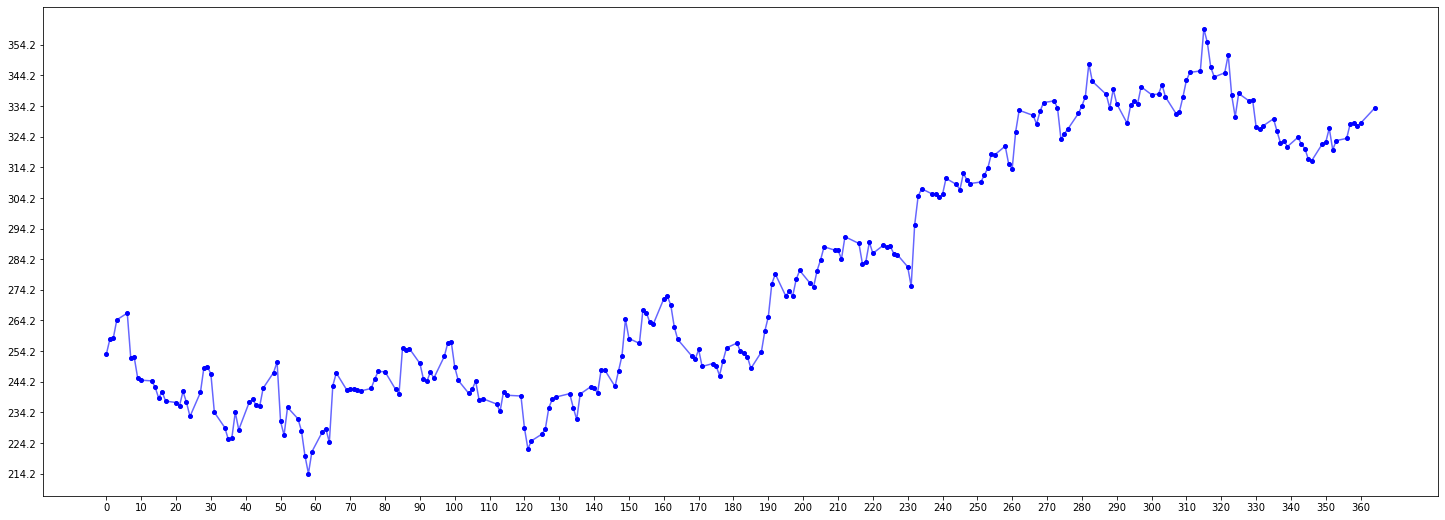

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
from time import mktime
from datetime import datetime

df = pd.read_csv('/home/max/MSFT.csv', parse_dates = True)
days = [datetime.fromtimestamp(mktime(time.strptime(df['Date'][i], '%Y-%m-%d'))) for i in range(df.shape[0])]
days_by_ind = [(days[i] - days[0]).days for i in range(df.shape[0])]
sales = pd.DataFrame(data = {'Day': days_by_ind, 'Close': df['Close']})

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25, 9))
plt.plot(np.array(sales['Day']), np.array(sales['Close']), 'ob', alpha = 1, markersize = 4)
plt.plot(np.array(sales['Day']), np.array(sales['Close']), 'b', alpha = 0.6)
plt.xticks(np.arange(0, max(days_by_ind), 10));
plt.yticks(np.arange(min(sales['Close']), max(sales['Close']), 10));

In [8]:
def make_plot(series1, series2, days1, days2):
    plt.figure(figsize=(25, 12))
    plt.subplot(2, 1, 1);
    plt.plot(np.array(days1), np.array(series1), 'ob', alpha = 1, markersize = 4);
    plt.plot(np.array(days1), np.array(series1), 'b', alpha = 0.6);
    plt.xticks(np.arange(0, max(days1), 10));
    plt.yticks(np.arange(min(series1), max(series1), 10));

    plt.subplot(2, 1, 2);
    plt.plot(np.array(days2), np.array(series2), "og");
    plt.plot(np.array(days2), np.array(series2), "g");
    plt.xticks(np.arange(0, max(days_by_ind), 10));

def make_plot_on_same_canvas(series1, series2, days1, days2):
    plt.figure(figsize=(25, 12))
    plt.xticks(np.arange(0, max(days1), 10));
    plt.yticks(np.arange(min(series1), max(series1), 10));
    plt.plot(np.array(days1), np.array(series1), 'b', alpha = 0.6);
    plt.plot(np.array(days2), np.array(series2), "r");

def make_num_of_plots_on_same_canvas(series, series1, days, days1, names):
    N = len(series1)
    fig, axs = plt.subplots(N, 1, sharey=False, tight_layout=False, figsize=(30, 15 * N))
    for i in range(N):
        axs[i].plot(np.array(days), np.array(series), 'b', alpha = 0.6);
        axs[i].plot(np.array(days1[i]), np.array(series1[i]), "r");
        axs[i].set_title(names[i])
        axs[i].title.set_size(20)
    plt.subplots_adjust(wspace = 0.5)


Модель Хольта-Винтерса.

Для тройного экспоненциального сглаживания, или модели Хольта-Винтерса
были использованы следующие формулы:

$l_{i} = x_{i},i = 0$

$l_{i} = \alpha\left( x_{i} - s_{i - p} \right) + (1 - \alpha)\left( l_{i - 1} + t_{i - 1} \right),i \neq 0$

$t_{i} = \beta\left( x_{i} - x_{i - 1} \right) + (1 - \beta)t_{i - 1}$

$s_{i} = \gamma\left( x_{i} - l_{i - 1} - t_{i - 1} \right) + (1 - \gamma)s_{i - p},i > p$

$\hat{x_{i + m}} = l_{i} + {mt}_{i} + s_{i - p + 1 + (m - 1)modp},$

где p — длина периода сезонности, m — номер периода, на который
происходит предсказание, $0 < \alpha < 1,0 < \beta < 1,0 < \gamma < 1$-
параметры модели.

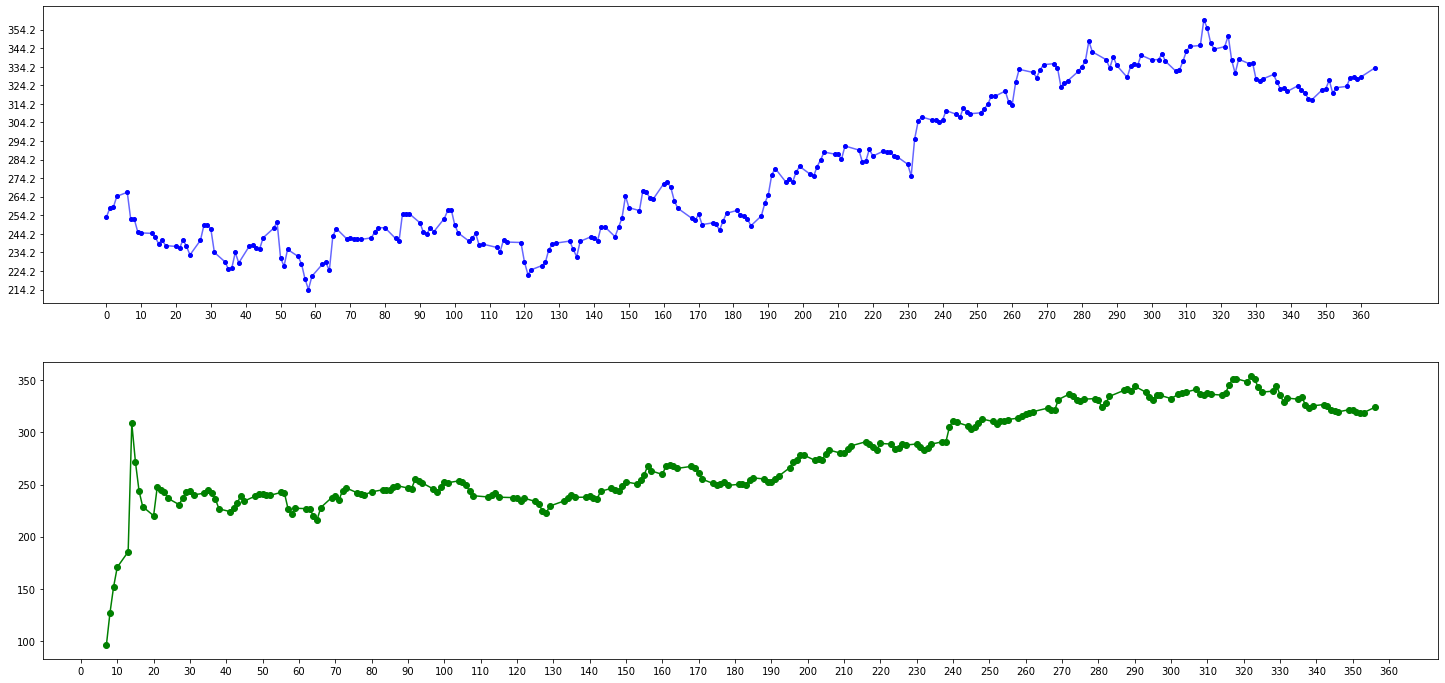

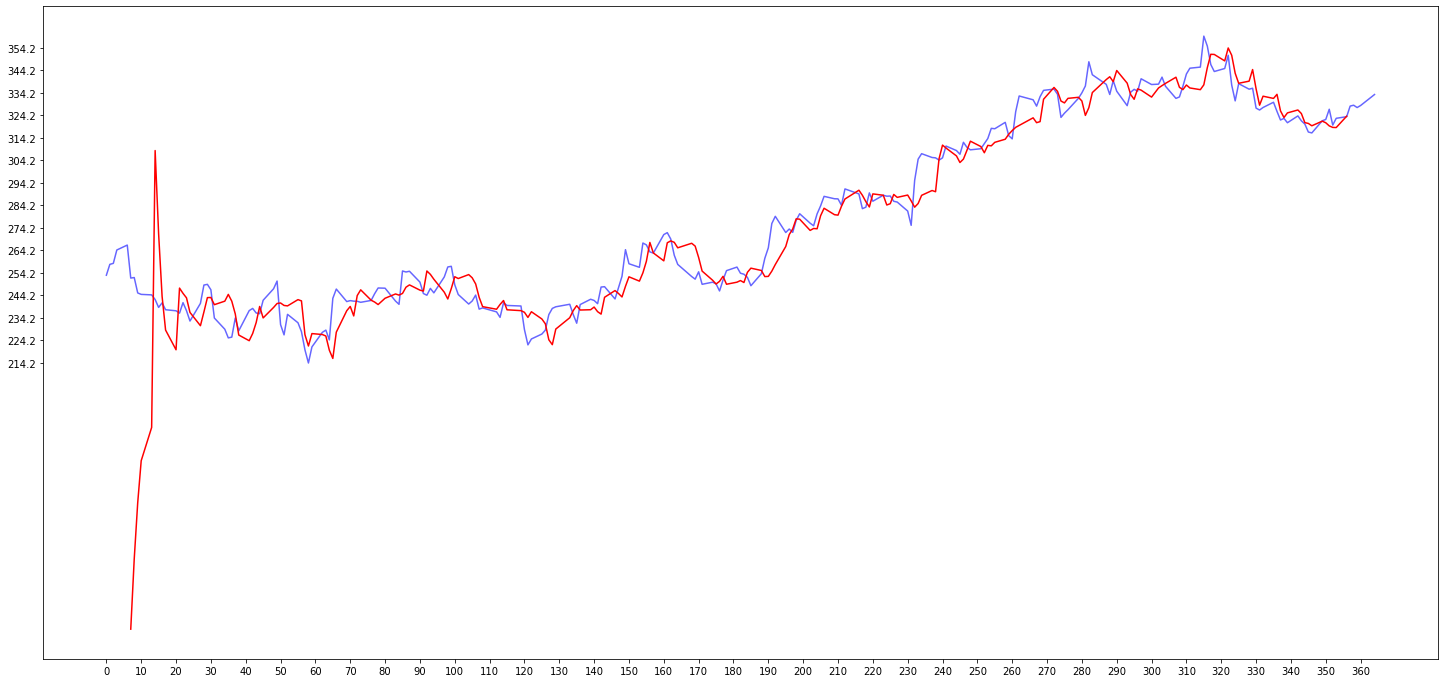

In [4]:
def prep_Holt_Winters(y, p, m, alpha = 0.5, betha = 0.5, gamma = 0.2):
    holt_winters_series = []
    l = [alpha * y[i] for i in range(p)]
    t = [0.0 for i in range(p)]
    s = [0.0 for i in range(p)]
    for i in range(p, len(y) - p):
        l.append(alpha * (y[i - 1] - s[i - p]) + (1 - alpha) * (l[i - 1] + t[i - 1]))
        t.append(betha * (l[i] - l[i - 1]) + (1 - betha) * t[i - 1])
        s.append(gamma * (y[i] - l[i - 1] - t[i - 1]) + (1 - gamma) * s[i - p])
    for i in range(p, len(y) - p):
        for j in range(m):
            holt_winters_series.append(l[i] + j * t[i] + s[i - p + 1 + j - 1 % p])
    return holt_winters_series

P = 5
hw_ser = prep_Holt_Winters(sales['Close'], p = P, m = 1, alpha = 0.2, betha = 0.00001, gamma = 0.7)

new_days = [sales['Day'][i] for i in range(P, len(sales['Day']) - P)]
make_plot(sales['Close'], hw_ser, sales['Day'], new_days)
make_plot_on_same_canvas(sales['Close'], hw_ser, sales['Day'], new_days)

### Ниже будут приведены сравнения результата сглаживания для различных параметров

1)α = 0.1; β = 0.5; γ = 0.001
2)α = 0.2; β = 0.2; γ = 0.2
3)α = 0.4; β = 0.1; γ = 0.5
4)α = 0.9; β = 0.1; γ = 1e-06
5)α = 0.0001; β = 0.0001; γ = 0.999999


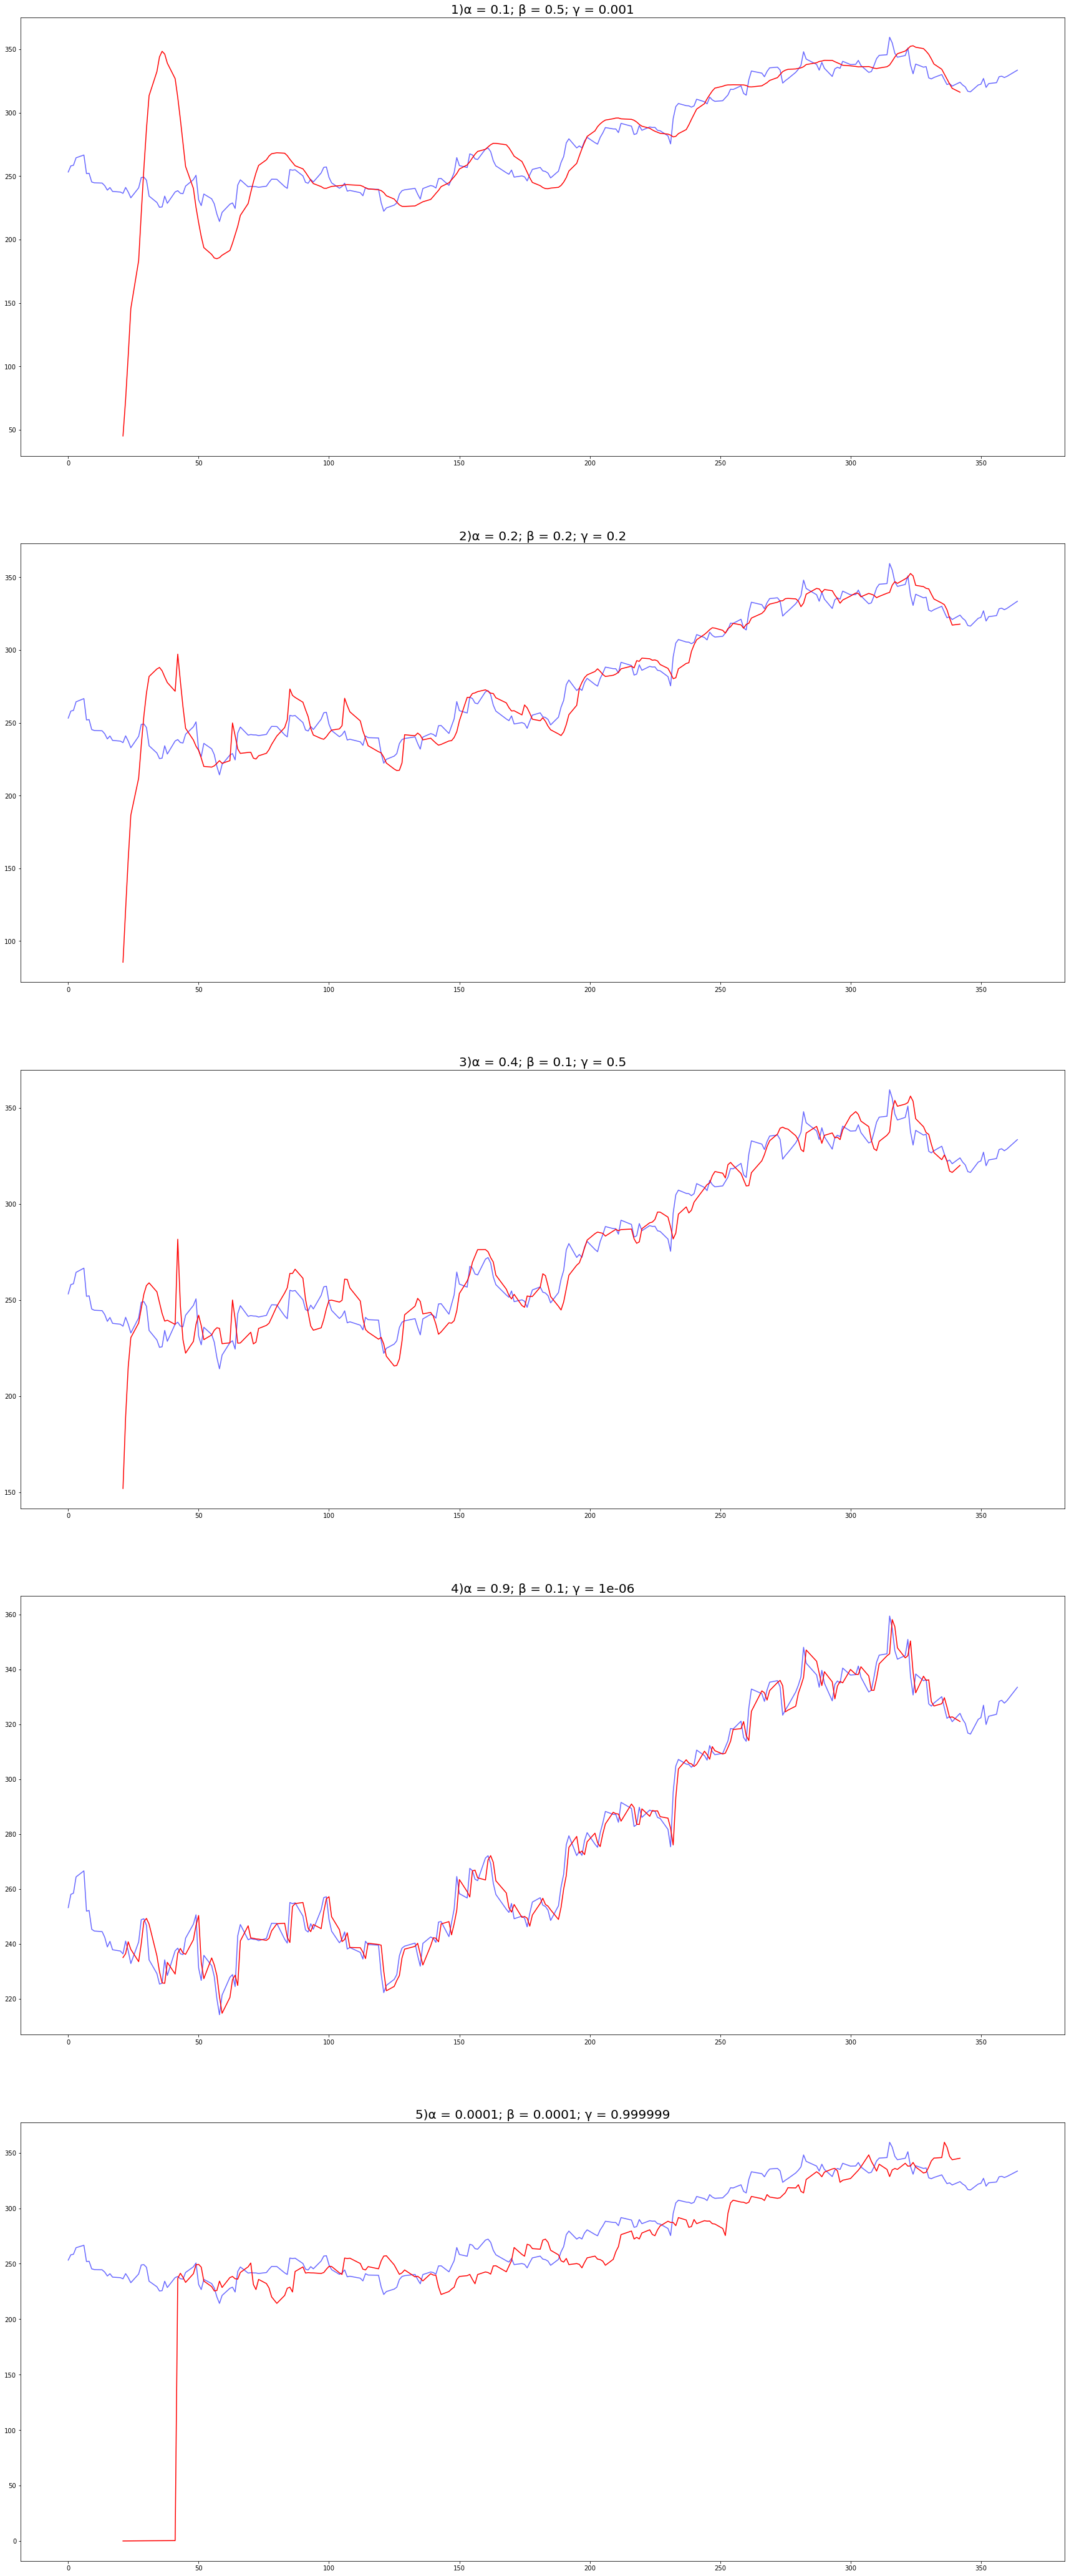

In [9]:
def holt_winters_series_plot(series, days, P, alphas, bethas, gammas):
    hw_sers = []
    days1 = []
    names = []
    for i in range(len(alphas)):
        alpha_i, betha_i, gamma_i = alphas[i], bethas[i], gammas[i]
        hw_ser = prep_Holt_Winters(sales['Close'], p = P, m = 1, alpha = alpha_i, betha = betha_i, gamma = gamma_i)
        new_days = [sales['Day'][i] for i in range(P, len(sales['Day']) - P)]
        hw_sers.append(hw_ser)
        days1.append(new_days)
        name_of_plot = f'{i + 1})\u03b1 = {alpha_i}; \u03b2 = {betha_i}; \u03b3 = {gamma_i}'
        names.append(name_of_plot)
        print(name_of_plot)
    return [hw_sers, days1, names]

p = 15
alphas = [0.1, 0.2, 0.4, 0.9, 0.0001]
bethas = [0.5, 0.2, 0.1, 0.1, 0.0001]
gammas = [0.001, 0.2, 0.5, 0.000001, 0.999999]
hw_sers = holt_winters_series_plot(sales['Close'], sales['Day'], p, alphas, bethas, gammas)
make_num_of_plots_on_same_canvas(sales['Close'], hw_sers[0], sales['Day'], hw_sers[1], hw_sers[2])